In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [ ]:
class Flow:
    def __init__(self, lines, parameters, compartments):
        self.equation = lines[0].replace('\n', '').replace("$0", lines[1][:-1]).replace("$1", lines[2][:-1])
        self.source = parse(read(lines[1])[0])
        self.sink = parse(read(lines[2])[0])
        self.name = parse(read(lines[3])[0])
        self.compiled_equation = compile(parse(read(self.equation)[0]), parameters, compartments)

    def __repr__(self):
        return f'Flow: equation{self.equation}'

class Function:
    def __init__(self, operator, operands) -> None:
        self.operator = operator
        self.operands = operands

    def __repr__(self):
        if isinstance(self.operator, WordOrSymbol) and self.operator.value == 'parameter':
            return f'parameter: {self.operands})'
        else:
            return f'Function: ({self.operator} {" ".join([str(o) for o in self.operands])})'

class Compartment:
    def __init__(self, labels) -> None:
        self.labels = labels

    def __repr__(self):
        return 'Compartment' + self.as_key()

    def as_key(self):
        return '[' + ','.join(self.labels) + ']'

class WordOrSymbol:
    def __init__(self, value: str) -> None:
        self.value = value

    def __repr__(self):
        return self.value

class ReadResult:
    def __init__(self, string_value: str, object_type: type) -> None:
        self.string_value = string_value
        self.object_type = object_type

def read(string: str, i: int = 0):
    string = string.replace('\n', ' ').replace('\t', ' ')
    beg = string[i]
    while string[i] == ' ':
        i += 1
    if beg == '(':
        return read_fn(string, i)
    elif beg == '[':
        return read_compartment(string, i)
    else:
        return read_word_or_symbol(string, i)

def read_fn(string: str, i: int):
    start = i
    depth = 0
    while True:
        if string[i] == '(':
            depth += 1
        elif string[i] == ')':
            depth -= 1
        i += 1
        if depth == 0:
            break
    return ReadResult(string[start:i], Function), i + 1

def read_compartment(string: str, i: int):
    start = i
    while string[i] != ']':
        i += 1
    # include the closing bracket
    i += 1
    return ReadResult(string[start:i], Compartment), i + 1

def read_word_or_symbol(string: str, i: int):
    start = i
    while i < len(string) and string[i] != ' ' and string[i] != '[' and string[i] != ')' and string[i] != '(':
        i += 1
    return ReadResult(string[start:i], WordOrSymbol), i + 1

def parse(read_result: ReadResult):
    parser = {
        Function: parse_fn,
        Compartment: parse_compartment,
        WordOrSymbol: parse_word_or_symbol
    }
    return parser[read_result.object_type](read_result.string_value)

def parse_fn(string: str):
    string = string[1:-1] # take `...` from `(...)`
    terms = []
    i = 0
    while i < len(string):
        if string[i] == ' ':
            i += 1
            continue
        r, i = read(string, i)
        terms += [parse(r)]
    return Function(terms[0], terms[1:])

def parse_compartment(string: str):
    if string[0] != '[' or string[-1] != ']':
        print(string, string[-1])
        raise Exception('called parse_compartment with invalid string')
    string = string[1:-1] # take `...` from `[...]`
    return Compartment([s.strip() for s in string.split(',')])

def parse_word_or_symbol(string: str):
    return WordOrSymbol(string)

def compile(parse_result, parameters, compartments):
    if isinstance(parse_result, Function):
        return compile_equation(parse_result, parameters, compartments)
    if isinstance(parse_result, Compartment):
        return compile_compartment(parse_result, compartments)
    if isinstance(parse_result, WordOrSymbol):
        return compile_word_or_symbol(parse_result)
    return parse_result

def compile_compartment(compartment: Compartment, compartments):
    s = set(compartment.labels)
    indices = [i for i, c in enumerate(compartments) if set(c).issuperset(s)]
    # if len(indices) == 1:
    #     return lambda state: state[indices[0]]
    # else:
    #     return lambda state: [state[i] for i in indices]
    return lambda state: [state[i] for i in indices]

def compile_word_or_symbol(word_or_symbol: WordOrSymbol,):
    return word_or_symbol

def evaluate_if_fn(x, parameters, compartments):
    if isinstance(x, Function):
        return evaluate_if_fn(compile_equation(x, parameters, compartments), parameters, compartments)
    else:
        return x

def compile_equation(equation: Function, parameters, compartments):
    if isinstance(equation.operator, WordOrSymbol):
        fn = equation.operator.value
        equation.operands = [evaluate_if_fn(x, parameters, compartments) for x in equation.operands]
        # parameters are a special function and could have their own
        # element in the grammar (such as the use of brackets) to denote them
        # but for now they are denoted using `(parameter ...)` like other functions
        if fn == 'parameter':
            prepare_parameter(equation.operands, parameters, compartments)
            parameters = get_parameters(equation.operands, parameters, compartments)
            return lambda state: [parameter.evaluate() for parameter in parameters]
        else:
            if fn == '*':
                if len(equation.operands) == 1:
                    raise 1
                compiled_operands = [compile(operand, parameters, compartments) for operand in equation.operands]
                return lambda state: product([operand(state) for operand in compiled_operands])
            elif fn == 'sumproduct':
                compiled_operands = [compile(operand, parameters, compartments) for operand in equation.operands]
                return lambda state: sumproduct([operand(state) for operand in compiled_operands])
            elif fn == 'join':
                join_using, join_seq = equation.operands[0], equation.operands[1]
                if not isinstance(join_using, WordOrSymbol):
                    raise Exception("Join first argument has to be a WordOrSymbol")
                if isinstance(join_seq, Compartment):
                    return WordOrSymbol(join_using.value.join(join_seq.labels))
                else:
                    # todo maybe something makes sense to implement here
                    raise Exception("Join second argument has to be a Compartment")
            elif fn == 'intersection':
                c1, c2 = equation.operands[0], equation.operands[1]
                if not isinstance(c1, Compartment):
                    raise Exception("Join first argument has to be a Compartment")
                if not isinstance(c2, Compartment):
                    raise Exception("Join second argument has to be a Compartment")
                return Compartment([x for x in c1.labels if x in c2.labels])
            else:
                raise Exception(f"Unknown function `{fn}`")
    else:
        raise Exception(f"Expected operator of type WordOrSymbol, received {type(equation.operator)}")

def product(terms):
    p = 1
    for t in terms:
        if isinstance(t, list):
            p *= sum(t)
        else:
            p *= t
    return p

def sumproduct(values):
    if type(values[0]) != list:
        print(len(values), list(map(type, values)))
        raise 1
    expected_len = len(values[0])
    for v in values:
        if len(v) != expected_len:
            raise Exception(f'could not broadcast matrices or vectors of sizes `{[len(v) for v in values]}` ({values})')
    return sum([product([value[i] for value in values]) for i in range(len(values[0]))])

def parse_compartments(line):
    return [parse_compartment(c) for c in line.replace('[[', '[').replace(']]', ']').replace('\n', '').split('], ')]

class Parameter:
    def __init__(self, operands, value) -> None:
        if type(operands) != type([]):
            raise 1
        self.operands = operands
        self.value = value

    def evaluate(self):
        if self.value is None:
            raise Exception(f"None valued parameter '{self.name}'")
        else:
            return self.value

class CompartmentValue:
    def __init__(self, compartment: Compartment, value) -> None:
        self.compartment = compartment
        self.value = value

    def evaluate(self):
        if self.value is None:
            raise Exception(f"None valued compartment {self.compartment.labels}")
        else:
            return self.value

def prepare_parameter(operands, parameters, compartments):
    for i, operand in enumerate(operands):
        if isinstance(operand, Compartment):
            is_full_compartment_specification = operand.labels in compartments
            if not is_full_compartment_specification:
                s = set(operand.labels)
                subsets_of_partial_specialization = [Compartment(c) for c in compartments if set(c).issuperset(s)]
                before, after = operands[:i], operands[i+1:]
                for c in subsets_of_partial_specialization:
                    prepare_parameter(before + [c] + after, parameters, compartments)
                return
    key = '(parameter'
    for op in operands:
        if isinstance(op, WordOrSymbol):
            key += ' ' + op.value
        if isinstance(op, Compartment):
            key += ' ' + op.as_key()
    key += ')'
    if key not in parameters:
        parameters[key] = Parameter(operands, None)

def get_parameters(operands, parameters, compartments):
    # check if any of our parameters are incomplete compartments (incomplete specifications)
    # those refer to all the compartments who's labels are a superset of our compartment's labels
    for i, operand in enumerate(operands):
        if isinstance(operand, Compartment):
            is_full_compartment_specification = operand.labels in compartments
            if not is_full_compartment_specification:
                s = set(operand.labels)
                subsets_of_partial_specialization = [Compartment(c) for c in compartments if set(c).issuperset(s)]
                before, after = operands[:i], operands[i+1:]
                res = []
                for c in subsets_of_partial_specialization:
                    params = get_parameters(before + [c] + after, parameters, compartments)
                    if isinstance(params, list):
                        res.extend(params)
                    else:
                        res.extend([params])
                return res
    # note we early return in the for loop if any compartment was incomplete
    # so at this point we are certain the parameters we have are complete
    key = '(parameter'
    for op in operands:
        if isinstance(op, WordOrSymbol):
            key += ' ' + op.value
        if isinstance(op, Compartment):
            key += ' ' + op.as_key()
    key += ')'
    return [parameters[key]]

def evalDelta(flows, state):
    res = 0
    for flow in flows:
        res += flow.compiled_equation(state)
    return res

def model_derivative(derivatives, state, t):
    print(f'\r{t}                                                         ', end='')
    state = [x if x > 0 else 0 for x in state]
    d = [derivatives[i](state) for i in range(len(state))]
    return d

def test_required_parameters(parameters):
    return [name for name, parameter in parameters.items() if parameter.value is None]

def readlines(fn):
    f = open(fn, 'r')
    l = f.readlines()
    f.close()
    return l

def identify_required_parameters(folder, project_name, provided_parameters):
    compartments = [parse_compartment(line[:-1]).labels for line in readlines(f'{folder}{project_name}.compartments.txt')]
    number_of_lines_per_flow_in_file = 5
    nl = number_of_lines_per_flow_in_file

    equation_file_lines = list(readlines(f'{folder}{project_name}.equations.txt')) + ['\n']
    n_eq = int(len(equation_file_lines) / nl)
    # nl = 5 -> [[0,1,2,3,4],[5,6,7,8,9],...]
    lines_of_each_eq = [equation_file_lines[i * nl:(i + 1) * nl] for i in range(n_eq)]
    flows = [Flow(lines_of_eq, provided_parameters, compartments) for lines_of_eq in lines_of_each_eq]
    flows = [f for f in flows if not 'Dead' in f.source.labels]

    return compartments, flows

def derivative_for(flows):
    return lambda state: evalDelta(flows[0], state) - evalDelta(flows[1], state)

def read_initial_conditions(folder, project_name, list_of_list_of_labels):
    compartments = [Compartment(c) for c in list_of_list_of_labels]
    initial_conditions = { c.as_key() : CompartmentValue(c, None) for c in compartments }
    for line in readlines(f'{folder}{project_name}.scenario-compartments.txt'):
        k, v = line.split('=')
        k = parse_compartment(k.strip()).as_key()
        if k not in initial_conditions:
            raise Exception(f"Provided population value in {folder}{project_name}.scenario-compartments.txt missing in {folder}{project_name}.compartments.txt")
        initial_conditions[k] = CompartmentValue(parse_compartment(k), float(v))
    return initial_conditions

def run_sim(folder, project_name, provided_parameters, compartments, flows, solver, t_span, tolerance=1e-4):
    compartments = [parse_compartment(line[:-1]).labels for line in readlines(f'{folder}{project_name}.compartments.txt')]
    number_of_lines_per_flow_in_file = 5
    nl = number_of_lines_per_flow_in_file

    equation_file_lines = list(readlines(f'{folder}{project_name}.equations.txt')) + ['\n']
    n_eq = int(len(equation_file_lines) / nl)
    # nl = 5 -> [[0,1,2,3,4],[5,6,7,8,9],...]
    lines_of_each_eq = [equation_file_lines[i * nl:(i + 1) * nl] for i in range(n_eq)]
    flows = [Flow(lines_of_eq, provided_parameters, compartments) for lines_of_eq in lines_of_each_eq]

    # each compartment has an in and an out list
    flowsbycompartment = [[[], []] for _ in compartments]
    for flow in flows:
        source = compartments.index(flow.source.labels)
        sink = compartments.index(flow.sink.labels)
        _in,_out = 0,1
        flowsbycompartment[source][_out] += [flow]
        flowsbycompartment[sink  ][_in ] += [flow]

    missing_parameters = test_required_parameters(provided_parameters)

    if len(missing_parameters) > 0:
        print("Missing Parameters:")
        for parameter in missing_parameters:
            print(parameter)
        raise Exception("Missing Parameters")
    else:
        derivatives = [derivative_for(flowsbycompartment[i]) for i in range(len(compartments))]
        initial_conditions = { Compartment(c).as_key() : CompartmentValue(Compartment(c), None) for c in compartments }
        for line in readlines(f'{folder}{project_name}.scenario-compartments.txt'):
            k, v = line.split('=')
            k = k.strip()
            initial_conditions[k] = CompartmentValue(parse_compartment(k.strip()), float(v))

        md = lambda state, t: model_derivative(derivatives, state, t)
        solution = solver(md, [initial_conditions[Compartment(c).as_key()].value for c in compartments], t_span, tolerance)
        print()
        return solution

def base_solver(model_derivative_f, initial_conditions, t_span, tolerance=1e-4):
    size = len(initial_conditions)
    state = initial_conditions
    res = [state]
    previous_t = t_span[0]
    for t in t_span[1:]:
        dt = t - previous_t
        model_derivative = model_derivative_f(state, previous_t)
        # sign something is wrong, steps too large, dangerous
        if (sum(np.abs(model_derivative)) * dt / sum(state)) > tolerance:
            # 10 steps 10 times smaller
            smaller_steps_sln = base_solver(model_derivative_f, state, linspace(previous_t, t, 10))
            # keep only the last
            state = smaller_steps_sln[-1]
        else:
            state = [state[i] + model_derivative[i] * dt for i in range(size)]

        state = [x if x > 0 else 0 for x in state]
        res += [state]
        previous_t = t
    return np.array(res)

# produces an array of length `n_steps + 1`
# interval [start, end] with `n_steps - 1` evenly spaced points in between
def linspace(start, end, n_steps: int):
    if n_steps < 1:
        raise Exception("n_steps has to be a positive integer greater or equal to 1")
    d = (end - start) / n_steps
    return [start + d * i for i in range(n_steps)] + [end]

In [ ]:
project_name = 'Tuite-Covid-Model-Stratified'
folder = f''

In [ ]:
parameters = {k.strip(): Parameter(parse_fn(k).operands, float(v)) for k, v in [s.split('=') for s in readlines(f'{folder}{project_name}.parameters.txt')]}

compartments, flows = identify_required_parameters(folder, project_name, parameters)
missing = [k for k, v in parameters.items() if v.value is None]

if len(missing) == 0:
    # solver = odeint
    solver = base_solver
    t_span = linspace(0, 1000, 1000) # + linspace(1, 10, 90) + linspace(10, 1000, 990)
    solution = run_sim(folder, project_name, parameters, compartments, flows, solver, t_span, tolerance=1e-1)
else:
    print(f'missing {len(missing)} parameters')
    fn = f'{folder}{project_name}.missing-parameters.txt'
    print(f'writing missing parameters to `{fn}`')

    with open(fn, 'w') as f:
        for p in missing:
            f.write(p + ' = 0\n')

999.0                                                         


In [ ]:
compartments[0]

['0-4',
 'Aging',
 'None',
 'S',
 'Tuite-Covid-Model',
 'Tuite-Covid-Model-Stratified',
 'comorbidity',
 'link']

In [ ]:
def plot_by_labels(list_of_list_of_labels, common_specs = []):
    f, ax = plt.subplots(1)
    for list_of_labels in list_of_list_of_labels:
        curves = []
        sub = set(list_of_labels + common_specs)
        for i, c in enumerate(compartments):
            if set(c).issuperset(sub):
                curves += [solution[:,i]]
        res = np.sum(np.array(curves), axis = 0)
        l = ax.plot(t_span, res, label=list_of_labels)
    ax.set_ylim(ymin=0)
    plt.legend()
    plt.title(f'plot for {common_specs}')
    plt.show()

In [ ]:
def sum_labels(list_of_list_of_labels, common_specs = []):
    curve = None
    for list_of_labels in list_of_list_of_labels:
        sub = set(list_of_labels + common_specs)
        for i, c in enumerate(compartments):
            if set(c).issuperset(sub):
                if curve is None:
                    curve = solution[:,i].copy()
                else:
                    curve += solution[:,i]
    return curve

In [ ]:
# def identify_problematic_equations(folder, project_name, provided_parameters, compartments, flows, solver):
#     compartments = [parse_compartment(line[:-1]).labels for line in readlines(f'{folder}{project_name}.compartments.txt')]
#     number_of_lines_per_flow_in_file = 5
#     nl = number_of_lines_per_flow_in_file

#     equation_file_lines = list(readlines(f'{folder}{project_name}.equations.txt')) + ['\n']
#     n_eq = int(len(equation_file_lines) / nl)
#     # nl = 5 -> [[0,1,2,3,4],[5,6,7,8,9],...]
#     lines_of_each_eq = [equation_file_lines[i * nl:(i + 1) * nl] for i in range(n_eq)]
#     flows = [Flow(lines_of_eq, provided_parameters, compartments) for lines_of_eq in lines_of_each_eq]

#     missing_parameters = test_required_parameters(provided_parameters)

#     if len(missing_parameters) > 0:
#         print("Missing Parameters:")
#         for parameter in missing_parameters:
#             print(parameter)
#         raise Exception("Missing Parameters")
#     else:
#         initial_conditions = { Compartment(c).as_key() : CompartmentValue(Compartment(c), None) for c in compartments }
#         for line in readlines(f'{folder}{project_name}.scenario-compartments.txt'):
#             k, v = line.split('=')
#             k = k.strip()
#             initial_conditions[k] = CompartmentValue(parse_compartment(k.strip()), float(v))

#         state = [initial_conditions[Compartment(c).as_key()].value for c in compartments]
#         for flow in flows:
#             val = flow.compiled_equation(state)
#             source = compartments.index(flow.source.labels)
#             if state[source] - val / 100 < 0:
#                 raise Exception(f"Source has value of {state[source]} and derivative is -{val}")

# parameters = {k.strip(): Parameter(parse_fn(k).operands, float(v)) for k, v in [s.split('=') for s in readlines(f'{folder}{project_name}.parameters.txt')]}
# compartments, flows = identify_required_parameters(folder, project_name, parameters)
# missing = [k for k, v in parameters.items() if v.value is None]
# identify_problematic_equations(folder, project_name, parameters, compartments, flows, solver)

In [ ]:
# for i, compartment in enumerate(compartments):
#     climbs_too_fast = solution[0][i] / (solution[1][i] + 1e-5) > 1.1
#     falls_too_fast = (solution[0][i] != 0) and ((solution[0][i] / (solution[1][i] + 1e-5)) < 0.1)
#     if climbs_too_fast or falls_too_fast:
#         print(i, compartment)
#         plot_by_labels([compartment])

In [ ]:
len(t_span) == len(solution)

True

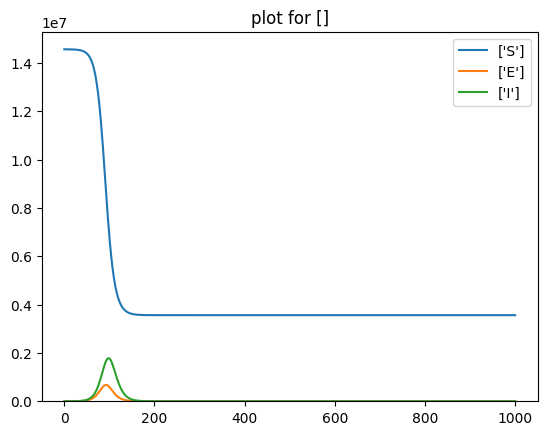

In [ ]:
plot_by_labels([['S'], ['E'], ['I']])

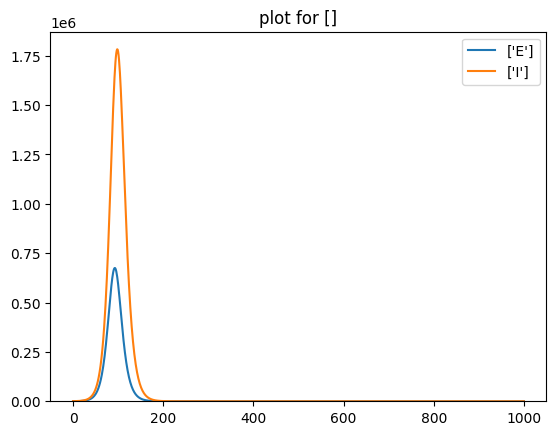

In [ ]:
plot_by_labels([['E'], ['I']])


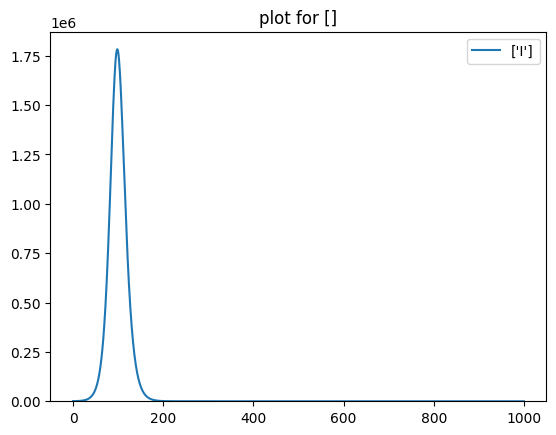

In [ ]:
plot_by_labels([['I']])